# Fitting the mean and variance of Praesepe.

In [1477]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco
import scipy.misc as spm

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 20,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Praesepe data.

In [1478]:
pr = pd.read_csv("data/praesepe.csv")
m = pr.prot > 0
m &= np.log10(pr.bp[m] - pr.rp[m]) < max(np.log10(pr.bp[m] - pr.rp[m]))

logbprp = np.log10(pr.bp[m] - pr.rp[m])
# logbprp = (pr.bp[m] - pr.rp[m])

logp = np.log10(pr.prot[m])
err = .434 * .1
logp_err = err * np.ones_like(logp)
log_age = np.ones(len(logp))*np.log10(650*1e6)
subcut = 450
eep = np.random.uniform(200, subcut, len(logp))

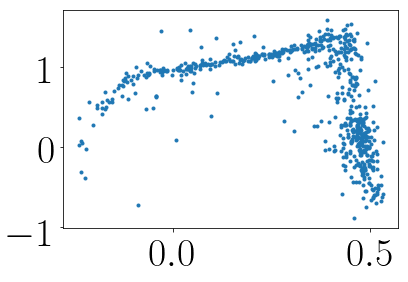

In [1479]:
plt.plot(logbprp, logp, ".")

In [1480]:
# def sigma_clip(x, y, yerr, sig=4):
#     finite_mask = np.isfinite(x) * np.isfinite(y)
#     x, y, yerr = x[finite_mask], y[finite_mask], yerr[finite_mask]
#     new_x, new_y, new_yerr = x*1, y*1, yerr*1
    
#     for i in range(10):
#         A = np.vander(new_x, 6)
#         ATA = np.dot(A.T, A)
#         pr = np.linalg.solve(ATA, np.dot(A.T, new_y))
#         y_pred = np.polyval(pr, new_x)
#         sigma = np.std(np.abs(new_y - y_pred))
#         outlier_mask = np.abs(new_y - y_pred) < sig*sigma
#         new_x, new_y, new_yerr = new_x[outlier_mask], new_y[outlier_mask], new_yerr[outlier_mask]
    
#     return new_x, new_y, new_yerr

# hot_mask = logbprp < .4
# x_clipped, y_clipped, yerr_clipped = sigma_clip(logbprp[hot_mask], logp[hot_mask], logp_err[hot_mask])
# plt.plot(x_clipped, y_clipped, ".")
# logbprp, logp, logp_err = x_clipped, y_clipped, yerr_clipped
# eep = np.random.uniform(200, subcut, len(logp))
# log_age = np.ones(len(logp))*np.log10(650*1e6)

Add the Sun.

In [1481]:
sun_age, sun_prot, sun_color = np.array([np.log10(4.56*1e9)]), np.array([np.log10(26)]), np.array([np.log10(.82)])
# sun_age, sun_prot, sun_color = np.array([np.log10(4.56*1e9)]), np.array([np.log10(26)]), np.array([.82])
sun_err, sun_eep = np.array([.0001]), np.array([355])

logbprp_sun = np.concatenate((logbprp, sun_color))
logp_sun = np.concatenate((logp, sun_prot))
log_age_sun = np.concatenate((log_age, sun_age))
logp_err_sun = np.concatenate((logp_err, sun_err))
eep_sun = np.concatenate((eep, sun_eep))

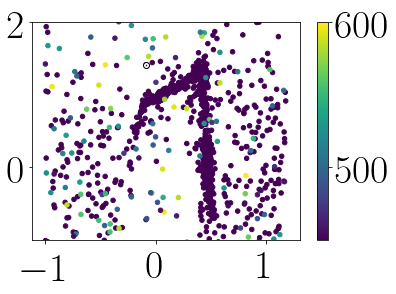

In [1482]:
# Now augment the data with hot stars, cool stars and giants.
nhot, ncool, nsub = 150, 400, 500
# nhot, ncool, nsub = 0, 0, 0

giant_eeps = np.random.uniform(subcut, 600, nsub)

# Color
logbprp_aug = np.concatenate((logbprp_sun, np.random.uniform(-1, -.25, nhot), np.random.uniform(.4, 1.2, ncool),
                              np.random.uniform(-1, 1.2, nsub)))
# logbprp_aug = np.concatenate((logbprp_sun, np.random.uniform(-1, .5, nhot),
#                               np.random.uniform(2.5, 5, ncool), np.random.uniform(-1, 5, nsub)))

# Period
logp_aug = np.concatenate((logp_sun, np.random.randn(nhot)*1 - .5, np.random.randn(ncool)*2 - .5,
                           np.random.randn(nsub)*(2*(giant_eeps/100.) - (subcut/100.))))

# Age
log_age_aug = np.concatenate((log_age_sun, np.ones(nhot)*np.log10(650*1e6), np.ones(ncool)*np.log10(650*1e6),
                              np.ones(nsub)*np.log10(650*1e6)))

# Period_err
logp_err_aug = np.concatenate((logp_err_sun, np.ones(nhot)*err, np.ones(ncool)*err,
                               np.ones(nsub)*err))

# EEP
eep_aug = np.concatenate((eep_sun, np.random.uniform(200, 420, nhot), np.random.uniform(200, 420, ncool),
                          giant_eeps))

# logbprp_aug = logbprp_sun
# logp_aug = logp_sun
# log_age_aug = log_age_sun
# logp_err_aug = logp_err_sun
# eep_aug = eep_sun

plt.scatter(logbprp_aug, logp_aug, c=eep_aug, s=20, vmin=subcut, vmax=600)
plt.plot(sun_color, sun_prot, "wo", markeredgecolor="k")
plt.plot(sun_color, sun_prot, "k.", ms=1)
plt.ylim(-1, 2)
# plt.xlim(-.5, .8)
plt.colorbar();

Text(0, 0.5, 'log(period)')

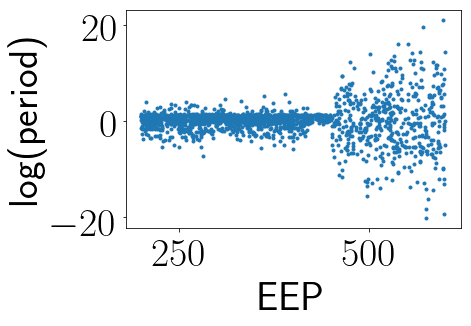

In [1483]:
plt.plot(eep_aug, logp_aug, ".")
plt.xlabel("EEP")
plt.ylabel("log(period)")

In [1484]:
def model(p, log_c, log_age):
    return np.polyval(p[:20], log_c) + p[20]*log_age
#     return np.polyval(p[:6], log_c) + p[6]*log_age

def variance(p, log_c, eep, prot_err):
    z = eep/100.
    return (prot_err + np.polyval(p[21:24], log_c) + np.polyval(p[24:], z))**2
#     return (prot_err + np.polyval(p[7:10], log_c) + np.polyval(p[10:], z))**2

In [1485]:
def lnlike(p, log_c, log_prot, log_age, eep, prot_err):
    mod = model(p, log_c, log_age)
    var = variance(p, log_c, eep, prot_err)
    return np.sum(-.5 * (mod - log_prot)**2/var - .5*np.log(2*np.pi*var))

def nll(p, log_c, log_prot, log_age, eep, prot_err):
    mod = model(p, log_c, log_age)
    var = variance(p, log_c, eep, prot_err)
    return np.sum((-.5 * (mod - log_prot)**2/var - .5*np.log(2*np.pi*var))*-1)

In [1486]:
p0 = np.ones(28)*.01
# p0 = np.ones(14)*.01

# print(np.shape(logbprp_aug), np.shape(logp_aug), np.shape(log_age_aug), np.shape(eep_aug), np.shape(logp_err_aug))
results = sco.minimize(nll, p0, args=(logbprp_aug, logp_aug, log_age_aug, eep_aug, logp_err_aug))
print(list(results.x))

[-8.55148146209452, 275.18860575809515, -214.94284696313815, -466.8577754579181, 98.50614433974263, -57.894764044263624, 637.7733653569124, 439.95996294413476, -229.64641760401483, -87.84998459721682, -1079.5351969988433, -230.59325704157186, 1175.3625667027288, 162.4557241202221, -430.4897358424117, -31.29455542325804, 49.46444665234455, -3.7522898361180705, 0.714777082586584, -5.305653400164669, 0.7082885269810122, 3.585797812110082, -0.19640957256070465, -6.246528651879711, 0.5208574135827294, -4.635825929237268, 13.429006437436662, -6.246528510805008]


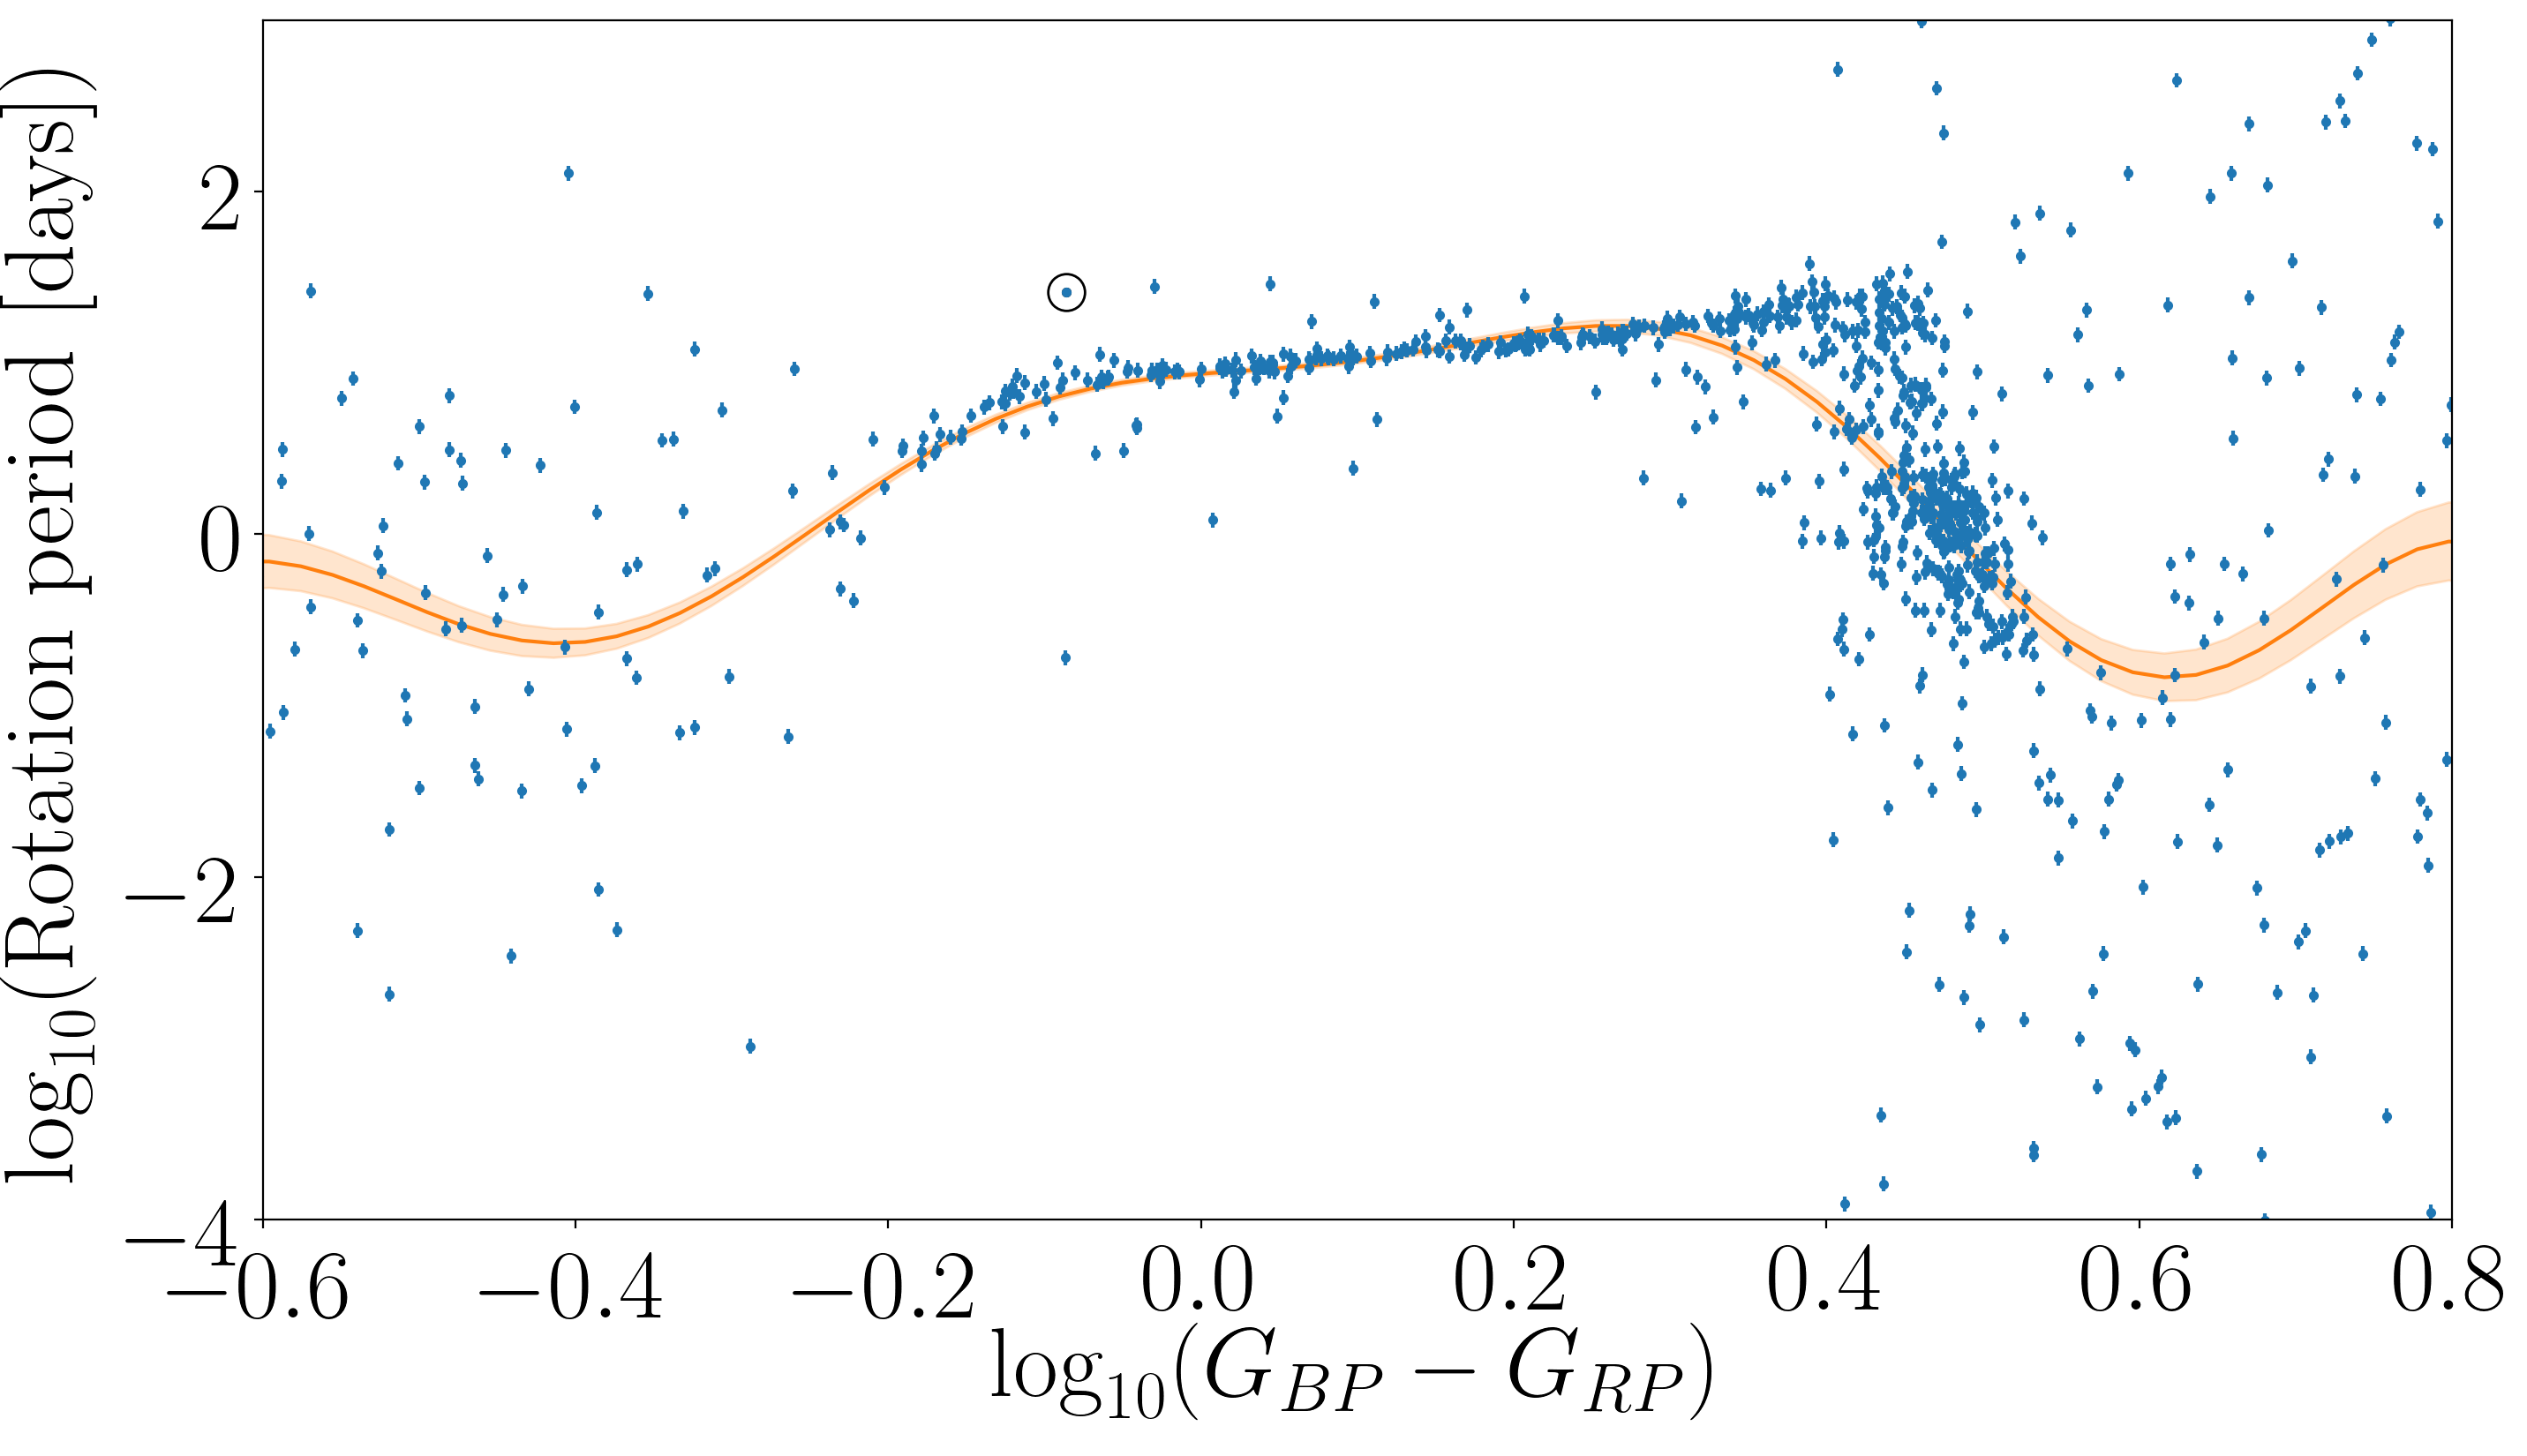

In [1487]:
x = np.linspace(-1, 1, 100)

plt.figure(figsize=(16, 9), dpi=200)

dwarfs = eep_aug < subcut
plt.errorbar(logbprp_aug[dwarfs], logp_aug[dwarfs], yerr=logp_err_aug[dwarfs], fmt=".");
plt.plot(x, model(results.x, x, np.log10(650*1e6)), zorder=1)

plt.plot(sun_color, sun_prot, "wo", markeredgecolor="k", ms=15, zorder=2)
plt.plot(sun_color, sun_prot, ".k", zorder=2)

plot_x = np.linspace(-.2, .6, 1000)
mean, var = model(results.x, x, np.log10(650*1e6)), variance(results.x, x, 350, np.ones_like(x)*.1);
sigma = np.sqrt(var) * .1
plt.fill_between(x, mean + sigma, mean - sigma, alpha=.2, color="C1", zorder=0);
plt.xlim(-.6, .8)
plt.ylim(-4, 3)
plt.xlabel("$\log_{10}(G_{BP} - G_{RP})$")
plt.ylabel("$\log_{10}(\mathrm{Rotation~period~[days]})$");

Text(0, 0.5, '$\\mathrm{Variance~[days^2]}$')

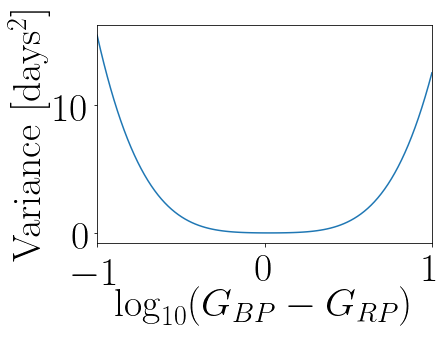

In [1488]:
plt.plot(x, var)
plt.xlim(-1, 1)
plt.xlabel("$\log_{10}(G_{BP} - G_{RP})$")
plt.ylabel("$\mathrm{Variance~[days^2]}$")

Text(0, 0.5, 'log(period)')

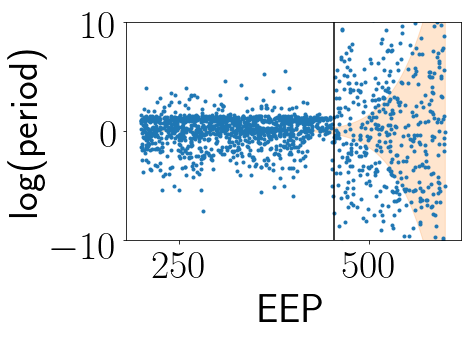

In [1489]:
def eep_variance(p, log_c, logprot_err):
    return (logprot_err + np.polyval(p, log_c))**2

eep_x = np.linspace(200, 600, 100)
eep_mean = np.zeros(len(eep_x))
eep_var = variance(results.x, 0., eep_x, err)*.1

# plt.figure(figsize=(16, 9))
plt.plot(eep_aug, logp_aug, ".")

plt.fill_between(eep_x, eep_mean + eep_var, eep_mean - eep_var, alpha=.2, color="C1");
plt.axvline(454, color="k")
plt.ylim(-10, 10)

plt.xlabel("EEP")
plt.ylabel("log(period)")

(0, 60)

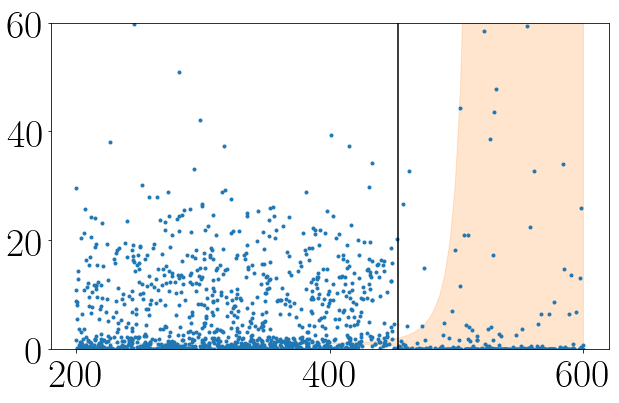

In [1490]:
plt.figure(figsize=(10, 6))
plt.plot(eep_aug, 10**logp_aug, ".")
plt.fill_between(eep_x, 10**(eep_mean + eep_var), 10**(eep_mean - eep_var), alpha=.2, color="C1");
plt.axvline(454, color="k")
plt.ylim(0, 60)

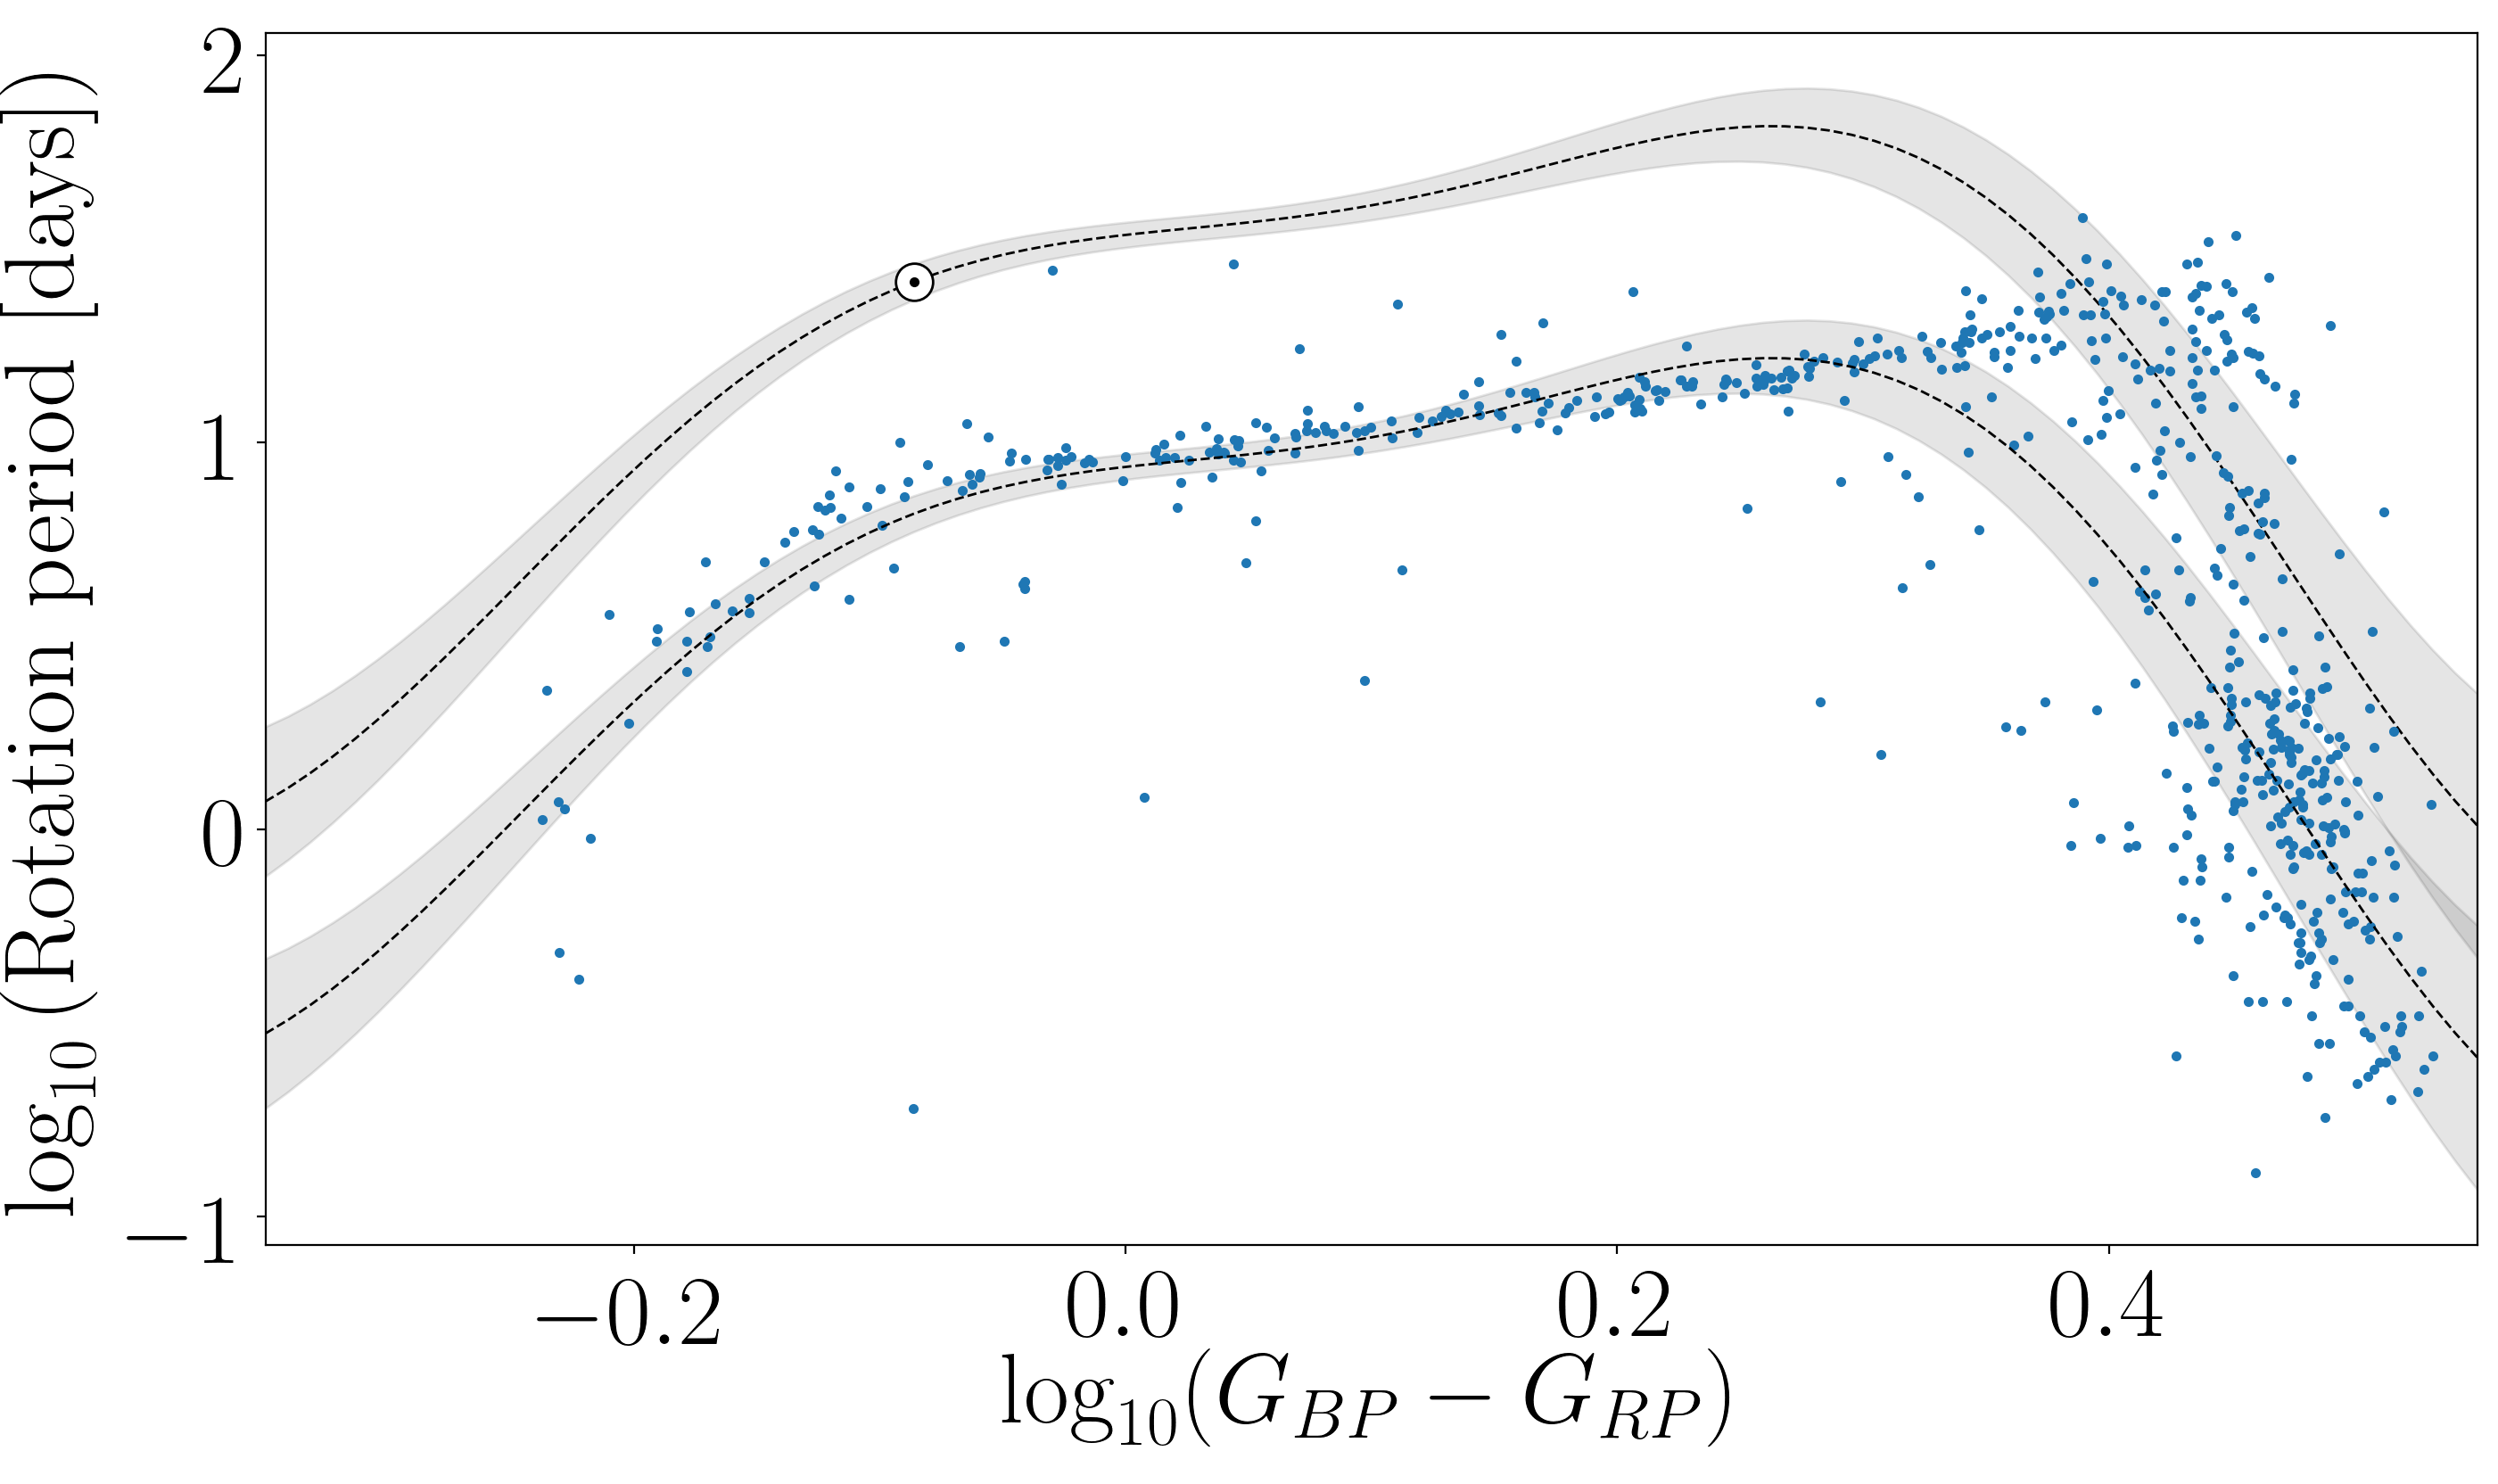

In [1491]:
best_fit = results.x

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(logbprp, logp, ".")
# dwarfs = generative_model(best_fit, logbprp, np.log10(650*1e6), np.ones_like(logbprp)*250, logp_err)
# plt.plot(logbprp, dwarfs, ".")

plot_x = np.linspace(-.35, .55, 100)
mean_praesepe = model(best_fit, plot_x, np.log10(650*1e6))
plot_var = variance(best_fit, plot_x, np.ones_like(plot_x)*355, np.ones_like(plot_x)*err)
plot_sig = np.sqrt(plot_var*.1)

plt.plot(plot_x, mean_praesepe, color="k", ls="--", lw=1, rasterized=True)
plt.fill_between(plot_x, mean_praesepe + plot_sig, mean_praesepe - plot_sig, color="k", alpha=.1, rasterized=True)

plt.plot(sun_color, sun_prot, "wo", markeredgecolor="k", ms=15, zorder=2, rasterized=True)
plt.plot(sun_color, sun_prot, ".k", zorder=2, rasterized=True)

mean_sun = model(best_fit, plot_x, np.log10(4.56*1e9))
plt.plot(plot_x, mean_sun, color="k", ls="--", lw=1, zorder=0, rasterized=True)
plt.fill_between(plot_x, mean_sun + plot_sig, mean_sun - plot_sig, color="k", alpha=.1, rasterized=True)
plt.xlim(-.35, .55)

plt.xlabel("$\log_{10}(G_{BP} - G_{RP})$")
plt.ylabel("$\log_{10}\mathrm{(Rotation~period~[days])}$");

Now as a loglog plot so the axes make more sense.

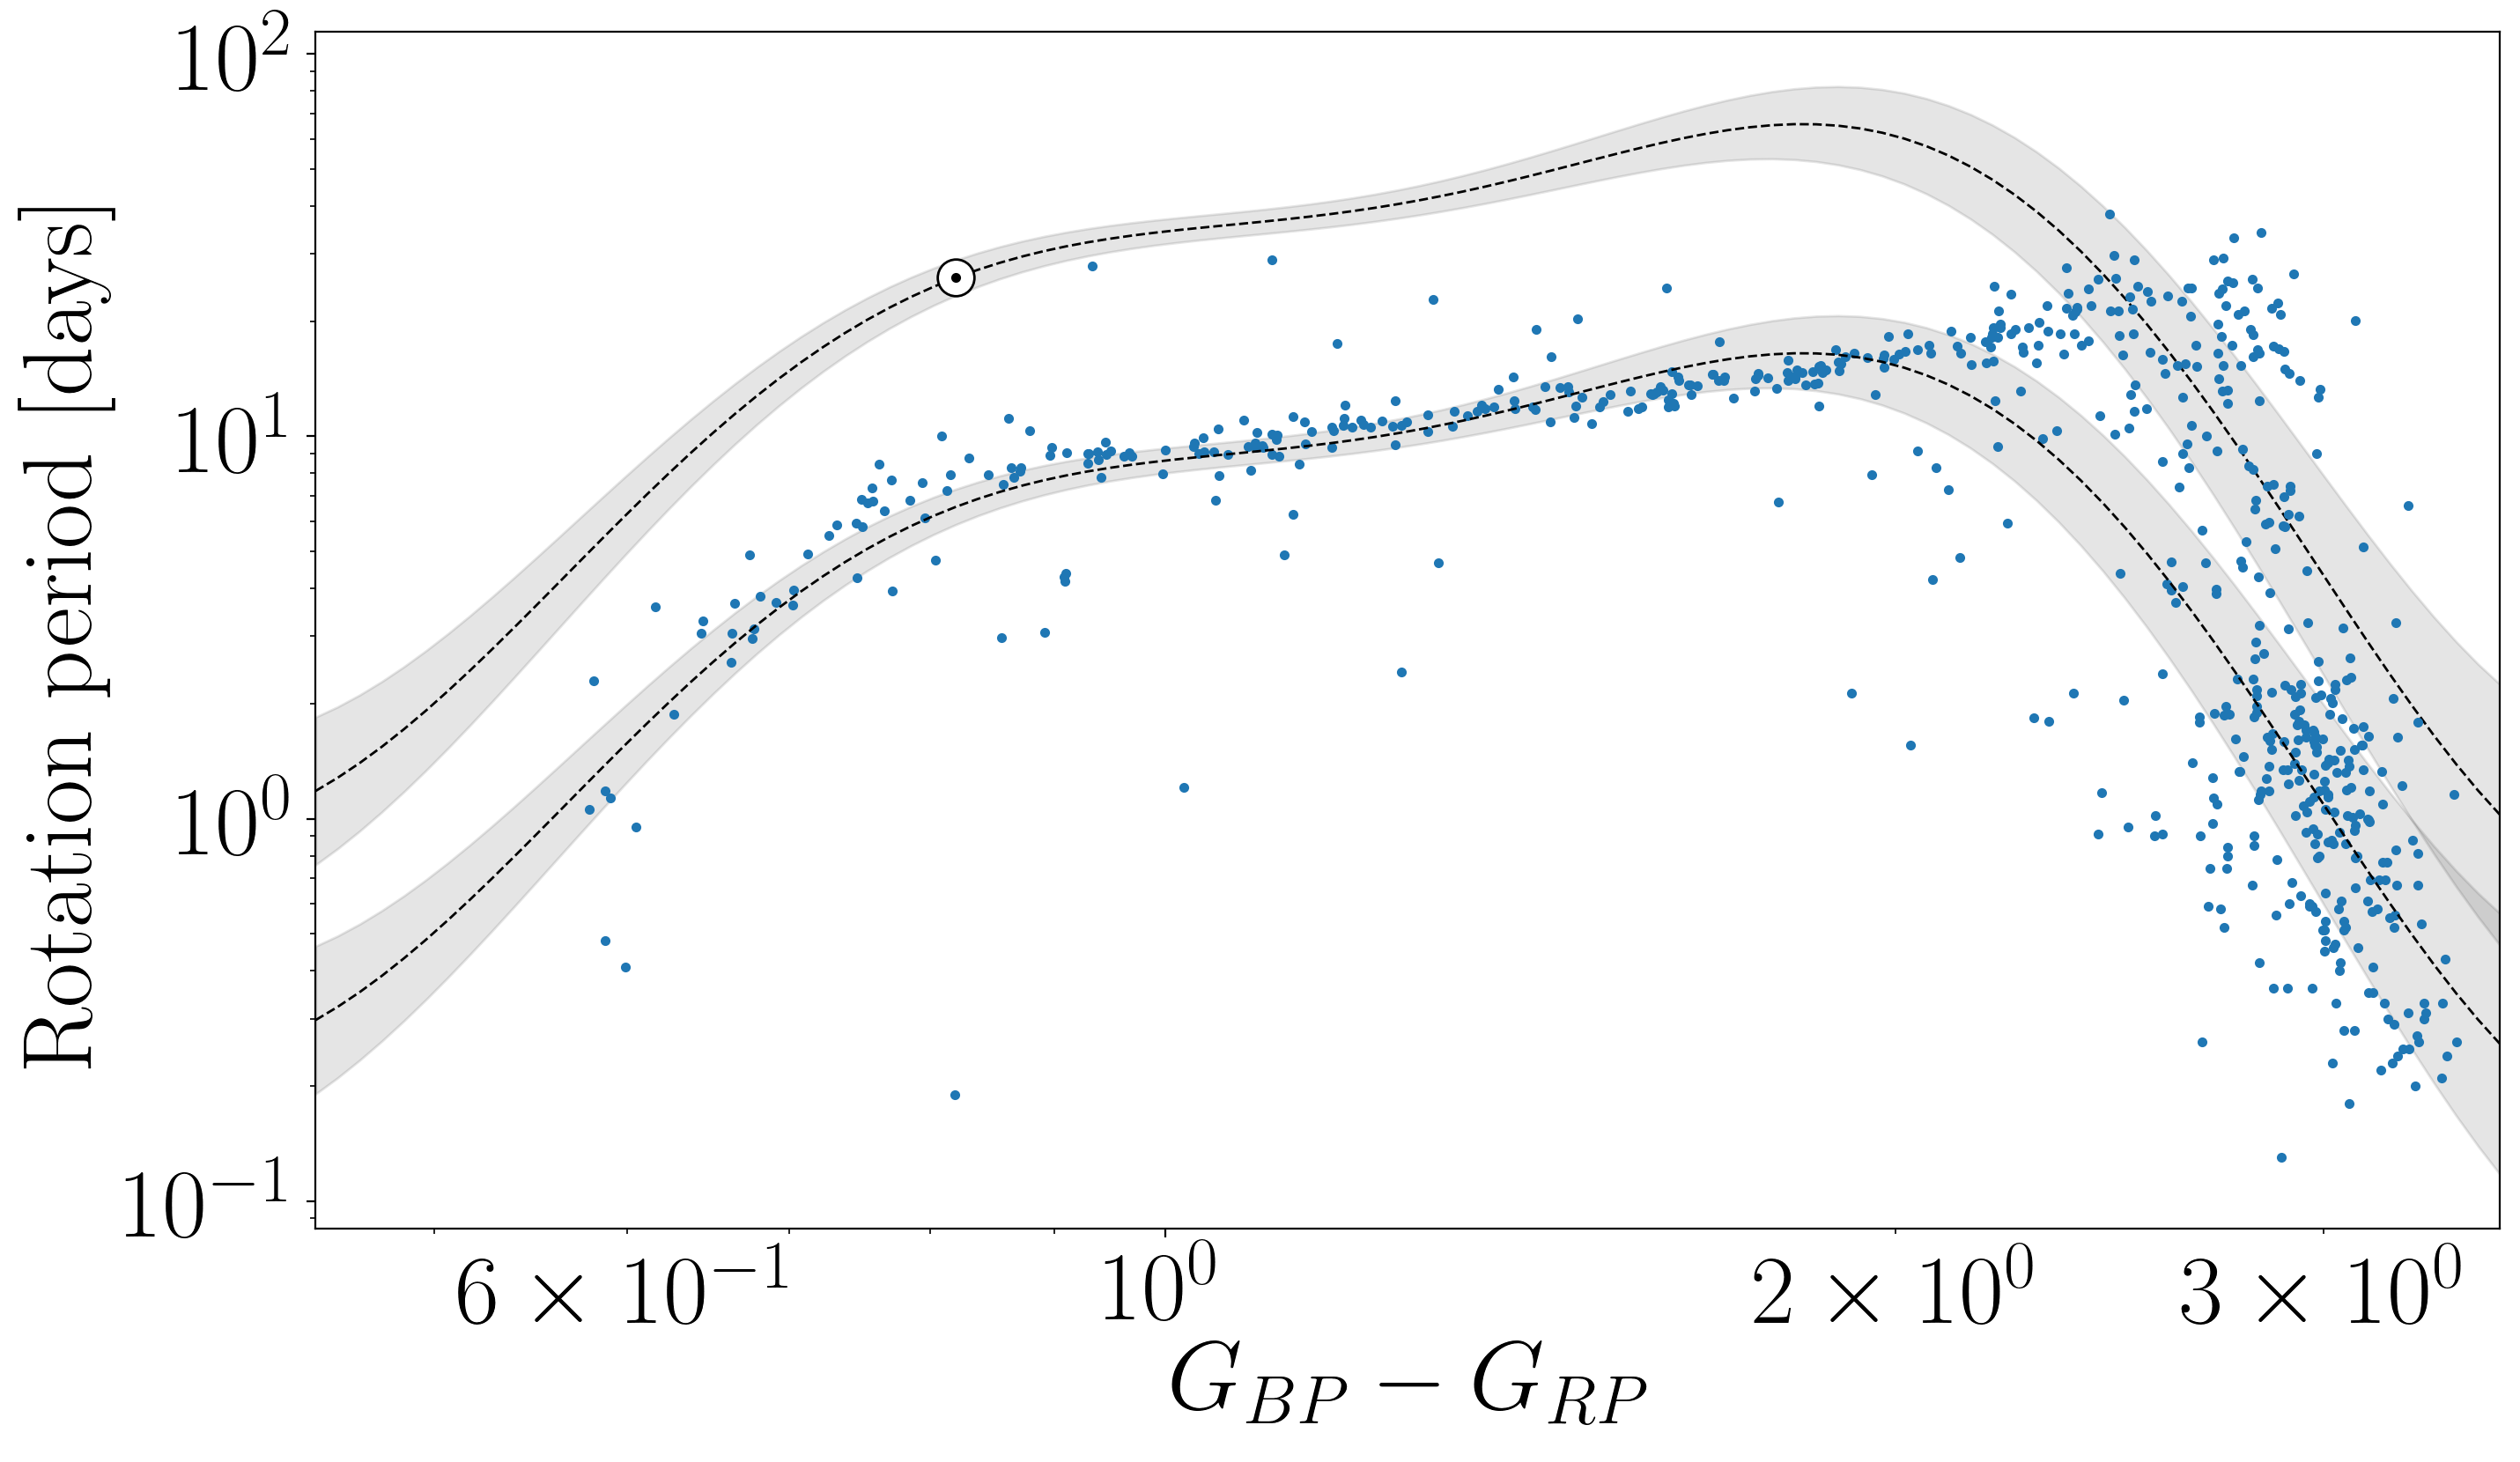

In [1492]:
plt.figure(figsize=(16, 9), dpi=200)

plt.loglog(10**logbprp, 10**logp, ".")
plt.loglog(10**plot_x, 10**mean_praesepe, color="k", ls="--", lw=1, rasterized=True)
plt.fill_between(10**plot_x, 10**(mean_praesepe + plot_sig), 10**(mean_praesepe - plot_sig),
                 color="k", alpha=.1, rasterized=True)

plt.loglog(10**sun_color, 10**sun_prot, "wo", markeredgecolor="k", ms=15, zorder=2, rasterized=True)
plt.loglog(10**sun_color, 10**sun_prot, ".k", zorder=2, rasterized=True)

plt.loglog(10**plot_x, 10**mean_sun, color="k", ls="--", lw=1, zorder=0, rasterized=True)
plt.fill_between(10**plot_x, 10**(mean_sun + plot_sig), 10**(mean_sun - plot_sig),
                 color="k", alpha=.1, rasterized=True)
plt.xlim(10**-.35, 10**.55)

plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$");

In [1493]:
print(list(results.x))

[-8.55148146209452, 275.18860575809515, -214.94284696313815, -466.8577754579181, 98.50614433974263, -57.894764044263624, 637.7733653569124, 439.95996294413476, -229.64641760401483, -87.84998459721682, -1079.5351969988433, -230.59325704157186, 1175.3625667027288, 162.4557241202221, -430.4897358424117, -31.29455542325804, 49.46444665234455, -3.7522898361180705, 0.714777082586584, -5.305653400164669, 0.7082885269810122, 3.585797812110082, -0.19640957256070465, -6.246528651879711, 0.5208574135827294, -4.635825929237268, 13.429006437436662, -6.246528510805008]


Now try a Gaussian mixture model.

(1000, 2)
(1701, 2)


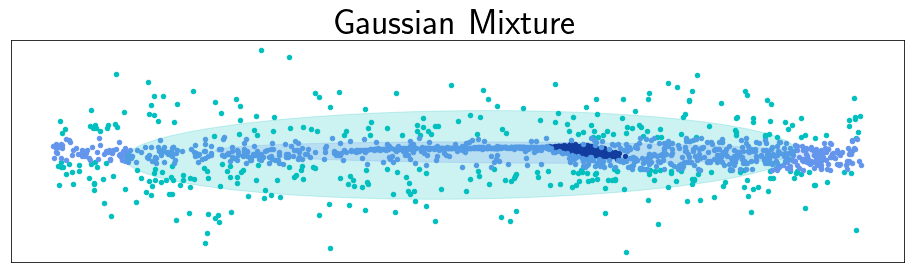

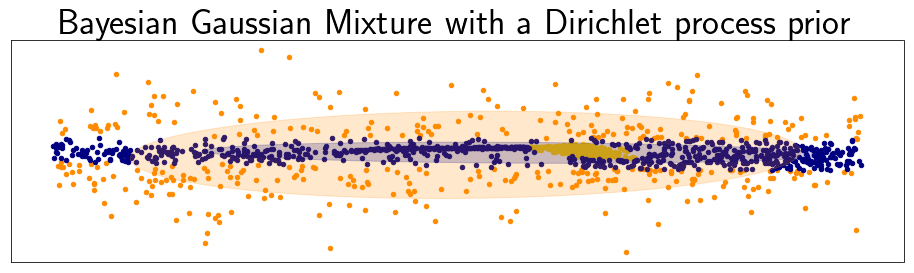

In [1494]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    plt.figure(figsize=(16, 9))
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 20, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.2)
        splot.add_artist(ell)

#     plt.xlim(-9., 5.)
#     plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]
print(np.shape(X))
X = np.vstack((logbprp_aug, logp_aug)).T
print(np.shape(X))

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=3,
                                        covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

In [1495]:
prior.

sigmoid.
Add variance in quadrature

power law in log variance.

SyntaxError: invalid syntax (<ipython-input-1495-3741e7a12b86>, line 1)

Sigmoid function

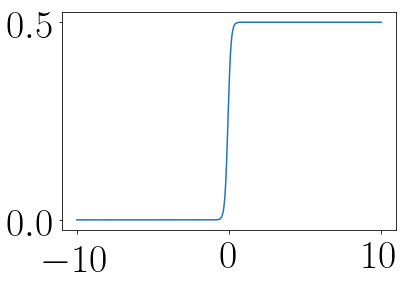

Broken power law.

In [1702]:
def bpl_model(p, logbprp, logage, br=.43):
    logp = np.zeros(len(logbprp))
    cool = logbprp >= .43
    hot = logbprp < -.25
    warm = (logbprp > -.25) * (logbprp <= .43)
    logp[warm] = np.polyval(p[:5], logbprp[warm]) + p[5]*logage[warm]
    logp[cool] = np.polyval(p[6:], logbprp[cool])
    logp[hot] = np.ones(len(logbprp[hot]))*0
    return logp

def bpr_nll(p, logbprp, logage, logp, logp_err):
    mod = bpl_model(p, logbprp, logage)
    var = logp_err**2
    return - np.sum(-.5 * (mod - logp)**2/var - .5*np.log(2*np.pi*var))

In [1703]:
p0_bpl = np.ones(8)
bpl_result = sco.minimize(bpr_nll, p0_bpl, args=(logbprp_sun, log_age_sun, logp_sun, np.ones_like(logp_sun)*.1))

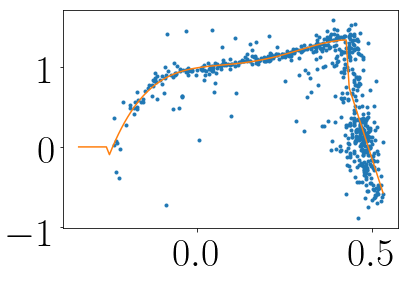

In [1730]:
plt.plot(logbprp_sun, logp_sun, ".")
xplot = np.linspace(min(logbprp_sun) - .1, max(logbprp_sun), 100)
plt.plot(xplot, bpl_model(bpl_result.x, xplot, np.ones_like(xplot)*np.log10(650*1e6)))

Do some aggressive sigma clipping.

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


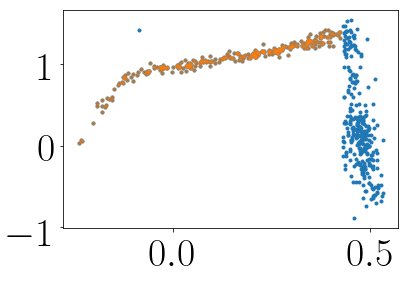

In [1731]:
def sigma_clip(x, y, yerr, sig=4, iterations=10):
    finite_mask = np.isfinite(x) * np.isfinite(y)
    x, y, yerr = x[finite_mask], y[finite_mask], yerr[finite_mask]
    new_x, new_y, new_yerr = x*1, y*1, yerr*1
    
    for i in range(iterations):
        A = np.vander(new_x, 6)
        ATA = np.dot(A.T, A)
        pr = np.linalg.solve(ATA, np.dot(A.T, new_y))
        y_pred = np.polyval(pr, new_x)
        sigma = np.std(np.abs(new_y - y_pred))
        outlier_mask = np.abs(new_y - y_pred) < sig*sigma
        new_x, new_y, new_yerr = new_x[outlier_mask], new_y[outlier_mask], new_yerr[outlier_mask]
    
    return new_x, new_y, new_yerr

hot_mask = logbprp < .43
x_clipped, y_clipped, yerr_clipped = sigma_clip(logbprp[hot_mask], logp[hot_mask], logp_err[hot_mask],
                                               iterations=20)

ncool, nhot = len(logbprp[~hot_mask]), len(x_clipped)
p_age = np.log10(650*1e6)
logbprp_clipped = np.concatenate((logbprp[~hot_mask], x_clipped, sun_color))
logp_clipped = np.concatenate((logp[~hot_mask], y_clipped, sun_prot))
logp_err_clipped = np.concatenate((logp_err[~hot_mask], yerr_clipped, np.array([.00001])))
log_age_clipped = np.concatenate((np.ones(len(logbprp[~hot_mask]))*p_age, np.ones(len(x_clipped))*p_age, sun_age))

plt.plot(logbprp_clipped, logp_clipped, ".")
plt.plot(x_clipped, y_clipped, ".", alpha=.5)

In [1732]:
bpl_result = sco.minimize(bpr_nll, p0_bpl, args=(logbprp_clipped, 
                                                 log_age_clipped, logp_clipped, 
                                                 np.ones_like(logp_clipped)*.1))

Text(0, 0.5, '$\\sigma$')

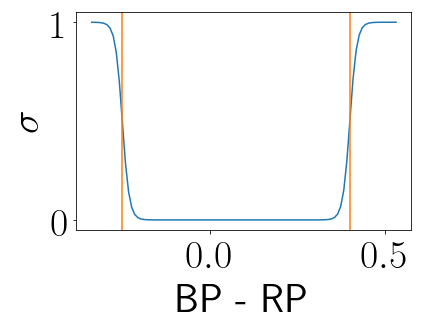

In [1773]:
k = 100

def sigmoid(k, x0, L, x):
    return L/(np.exp(-k*(x - x0)) + 1)

sigma = sigmoid(k, .4, 1., xplot) + sigmoid(k, .25, 1., -xplot)

plt.plot(xplot, sigma)
plt.axvline(.4, color="C1")
plt.axvline(-.25, color="C1")

plt.xlabel("BP - RP")
plt.ylabel("$\sigma$")

# def sigmoid_variance(bprp, eep):
#     return sigmoid(k, .4, xplot) + sigmoid(k, .25, -xplot)

Text(0, 0.5, '$\\sigma$')

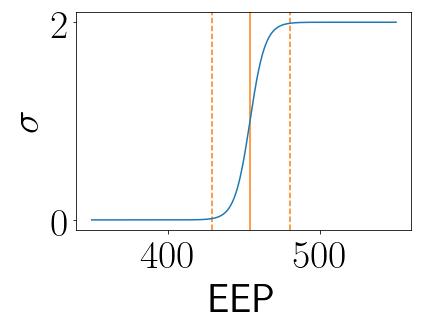

In [1785]:
eep_plot = np.linspace(350, 550, 1000)
sigma_eep = sigmoid(.2, 454, 2., eep_plot)
plt.axvline(454, color="C1")
plt.axvline(429, color="C1", ls="--")
plt.axvline(480, color="C1", ls="--")
plt.plot(eep_plot, sigma_eep)
plt.xlabel("EEP")
plt.ylabel("$\sigma$")

Text(0, 0.5, '$\\log_{10}(\\mathrm{Rotation~period~[days]})$')

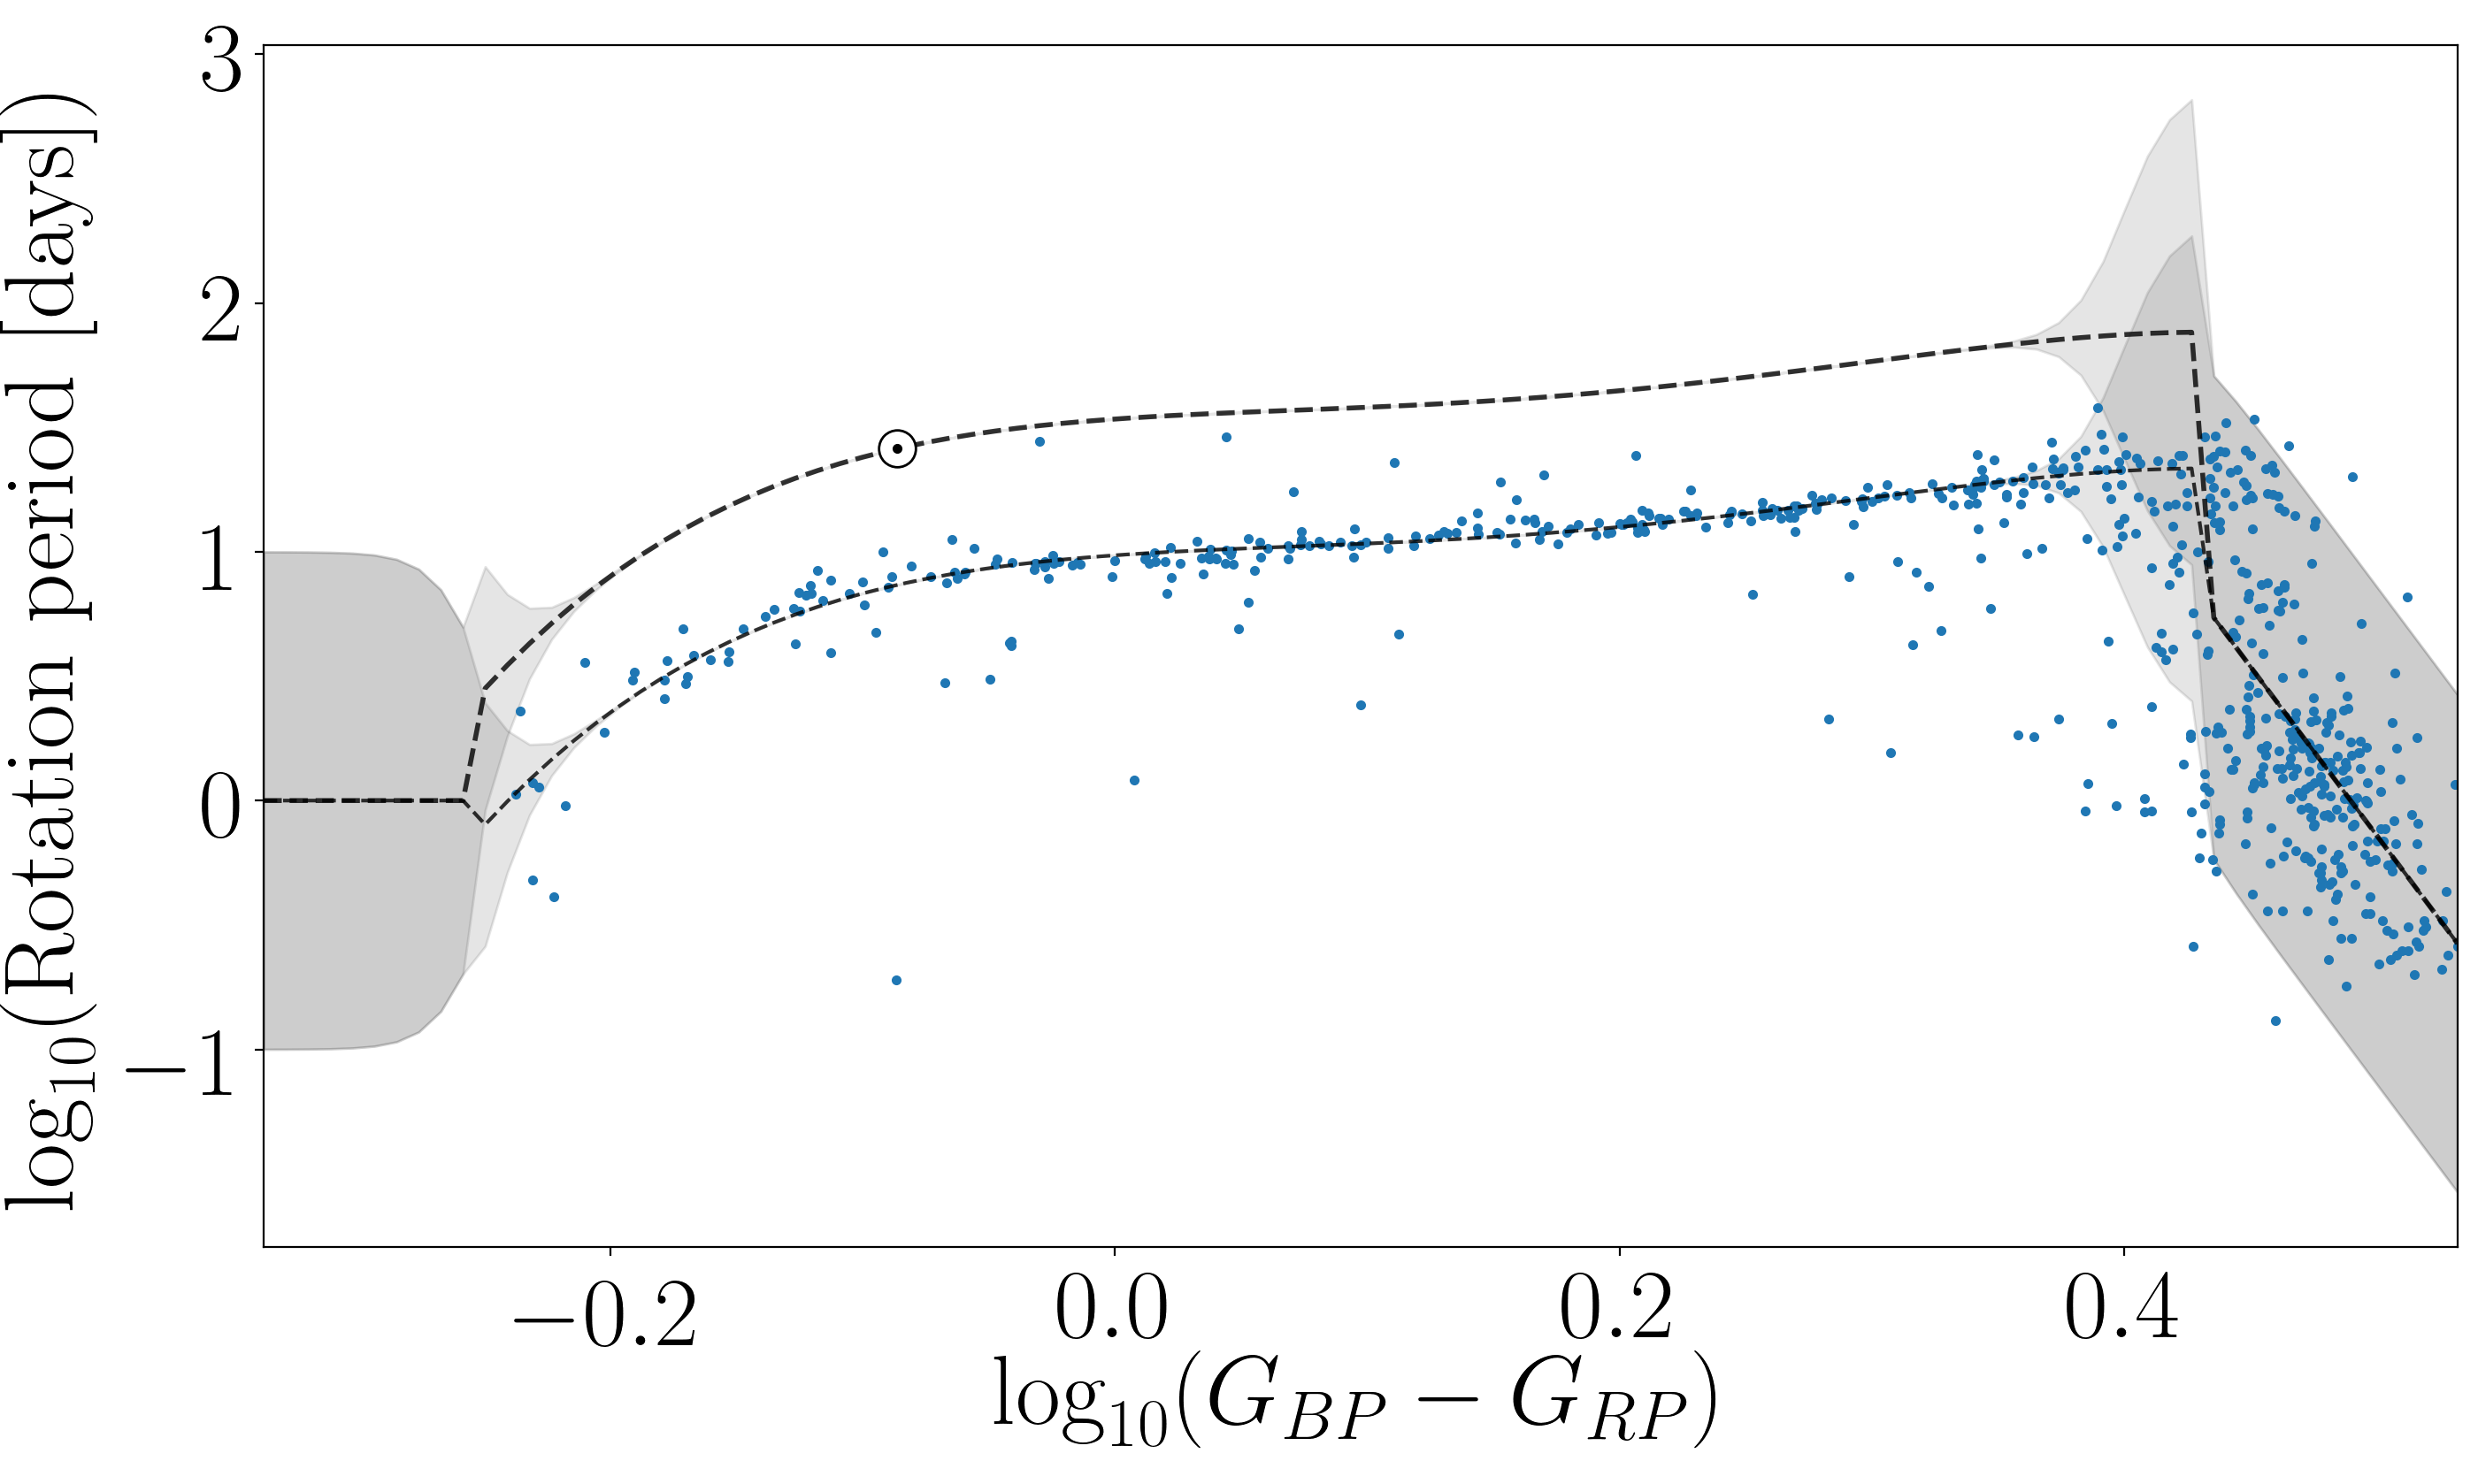

In [1755]:
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(logbprp_sun, logp_sun, ".", zorder=1)

mean = bpl_model(bpl_result.x, xplot, np.ones_like(xplot)*np.log10(4.56*1e9))
plt.plot(xplot, mean, lw=2, zorder=2, color="k", ls="--", alpha=.8, rasterized=True)
plt.fill_between(xplot, mean - sigma, mean + sigma, color="k", alpha=.1, rasterized=True)

mean = bpl_model(bpl_result.x, xplot, np.ones_like(xplot)*np.log10(650*1e6))
plt.fill_between(xplot, mean - sigma, mean + sigma, color="k", alpha=.1, rasterized=True)
plt.plot(xplot, mean, color="k", ls="--", alpha=.8, rasterized=True)

plt.plot(sun_color, sun_prot, "wo", markeredgecolor="k", ms=15, zorder=2, rasterized=True)
plt.plot(sun_color, sun_prot, ".k", zorder=2, rasterized=True)

plt.xlim(min(xplot), max(xplot))

plt.xlabel("$\log_{10}(G_{BP} - G_{RP})$")
plt.ylabel("$\log_{10}(\mathrm{Rotation~period~[days]})$")

Text(0, 0.5, '$\\mathrm{Rotation~period~[days]}$')

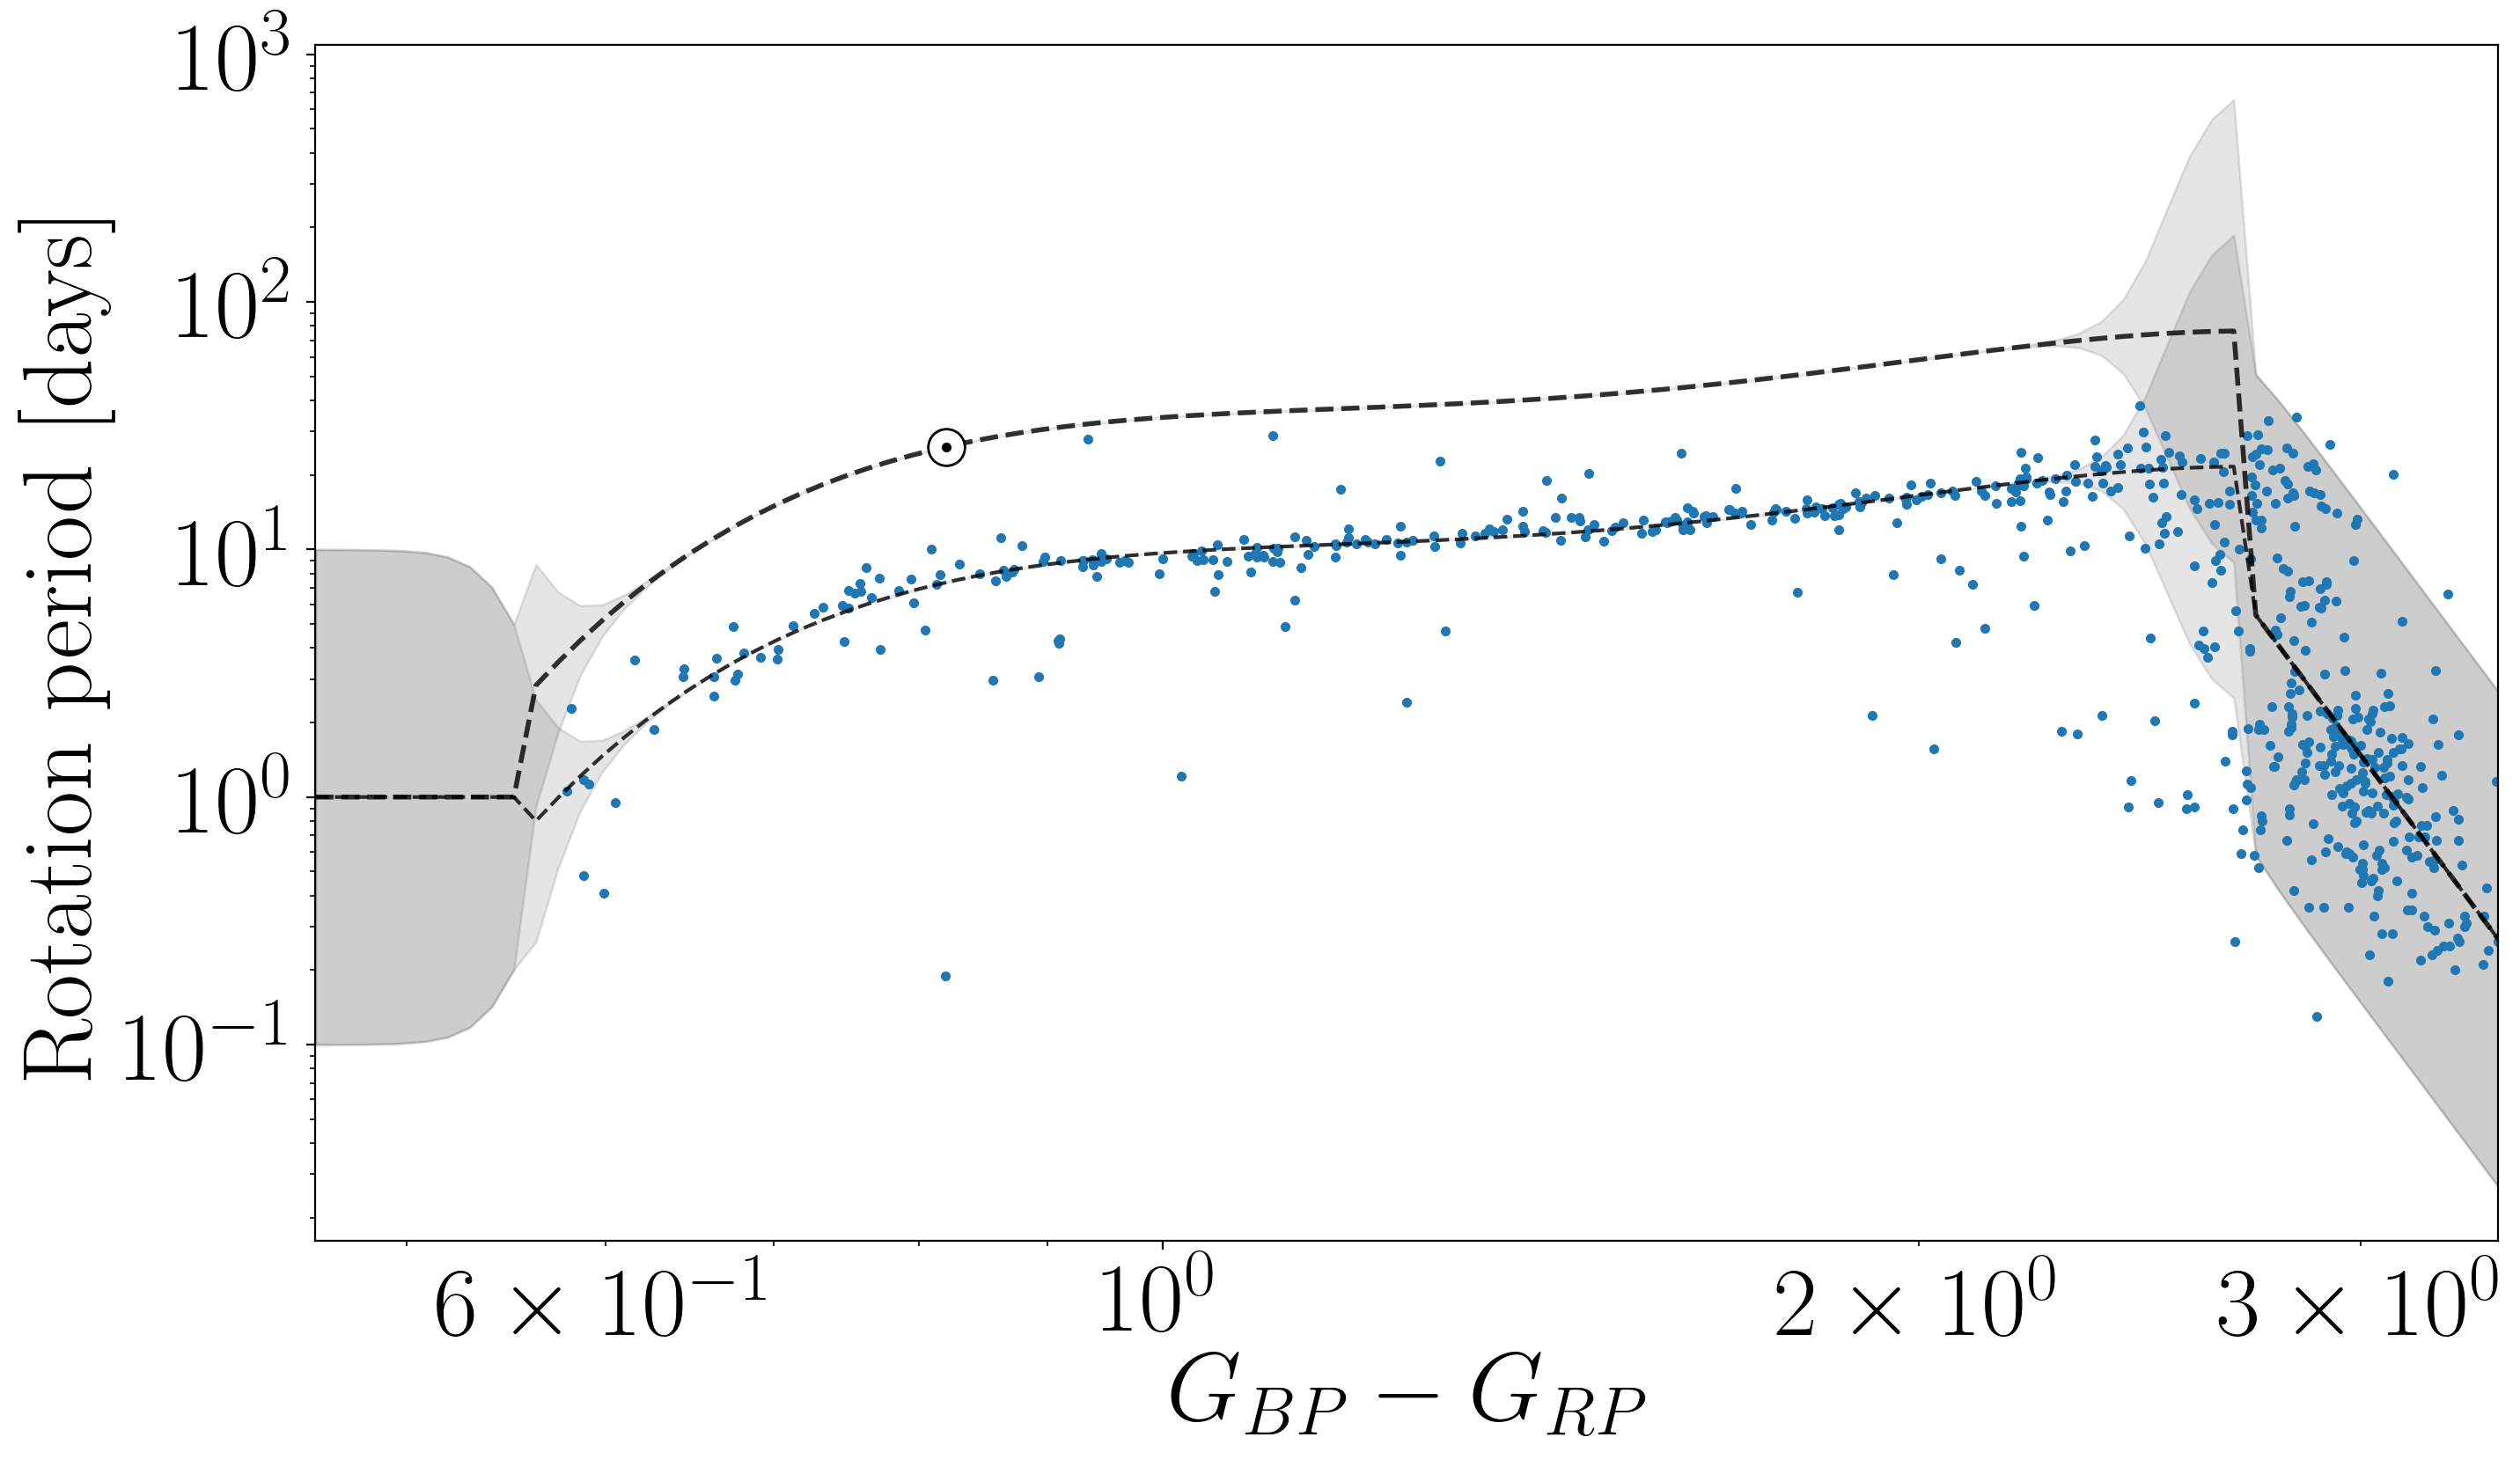

In [1793]:
plt.figure(figsize=(16, 9), dpi=200)
plt.loglog(10**logbprp_sun, 10**logp_sun, ".", zorder=1)

mean = bpl_model(bpl_result.x, xplot, np.ones_like(xplot)*np.log10(4.56*1e9))
plt.loglog(10**xplot, 10**mean, lw=2, zorder=2, color="k", ls="--", alpha=.8, rasterized=True)
plt.fill_between(10**xplot, 10**(mean - sigma), 10**(mean + sigma), color="k", alpha=.1, rasterized=True)

mean = bpl_model(bpl_result.x, xplot, np.ones_like(xplot)*np.log10(650*1e6))
plt.fill_between(10**xplot, 10**(mean - sigma), 10**(mean + sigma), color="k", alpha=.1, rasterized=True)
plt.loglog(10**xplot, 10**mean, color="k", ls="--", alpha=.8, rasterized=True)

plt.loglog(10**sun_color, 10**sun_prot, "wo", markeredgecolor="k", ms=15, zorder=2, rasterized=True)
plt.loglog(10**sun_color, 10**sun_prot, ".k", zorder=2, rasterized=True)

plt.xlim(10**min(xplot), 10**max(xplot))
# plt.ylim(.03, 500)

plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")